In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:


log_file = 'data/driving_log.csv'
image_folder = 'data/img_center'

driving_log = pd.read_csv(log_file)
    
#X_train, y_train = train['features'], train['labels']
#X_test, y_test = test['features'], test['labels']

driving_log shape: (8036, 7)
driving_log_1: IMG/center_2016_12_01_13_30_48_404.jpg
IMG/center_2016_12_01_13_30_48_404.jpg
XF.shape: (8036, 64, 200, 3)
(8036,)


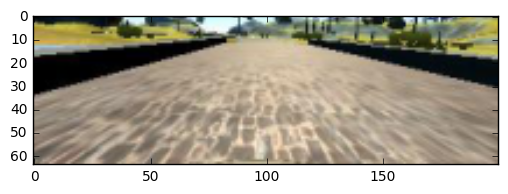

In [146]:
print('driving_log shape:', driving_log.shape)
print('driving_log_1:', driving_log['center'][1])

print(driving_log['center'][1])

X = []
Y = []

def get_image(idx):
    img_path = 'data/' + driving_log['center'][idx]
    y = driving_log['steering'][idx]
    img = mpimg.imread(img_path) #load_img(img_path) #, target_size=(224, 224))
    #img = img.resize((50, 50))
    #plt.imshow(img)
    #plt.show()
    
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    #x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    crop_img = x[50:140, :, :] #140/160 so that we don't see the car. 50 so that we don't see the sky (issue if car goes on hill?)
    resized_image = cv2.resize(crop_img, dsize = (200, 64), interpolation =  cv2.INTER_AREA ) 
    #resized_image = cv2.resize(crop_img, None,fx=.5, fy=.5, interpolation =  cv2.INTER_AREA ) 
    return resized_image,[y]

for i in range(driving_log.shape[0]):
    x,y = get_image(i)
    X.append(x)
    Y.append(y)

XF = np.stack(X)
XF = XF.astype(np.uint8)

print('XF.shape:',XF.shape)

YF = np.stack(Y).reshape(-1,)
print(YF.shape)

plt.imshow(XF[0])
plt.show()

# DO NOT DELETE THIS
#img_path = 'data/IMG/center_2016_12_01_13_30_48_404.jpg'
#image = mpimg.imread(img_path)  #mpimg.imread, cv2.imread not ok
#print('mpimg:', image[0,0])
#plt.imshow(image)
#plt.show()

#image = cv2.imread(img_path)  #mpimg.imread (RGB), cv2.imread not ok (BGR)
#print('cv2:', image[0,0])
#plt.imshow(image)
#plt.show()

#print(image)

#resized_image = cv2.resize(image, dsize = (150, 150), interpolation =  cv2.INTER_CUBIC ) 
#print('resized')
#plt.imshow(resized_image)
#plt.show()



In [147]:
validation_percentage = 0.2
X_train, X_valid, y_train , y_valid = train_test_split(XF, YF, test_size=validation_percentage)

# Downsample for performance
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

print("Training set shape:", X_train.shape, " - target shape:", y_train.shape)
print("Valid set shape:", X_valid.shape, " - target shape:", y_valid.shape)

Training set shape: (6428, 64, 200, 3)  - target shape: (6428,)
Valid set shape: (1608, 64, 200, 3)  - target shape: (1608,)


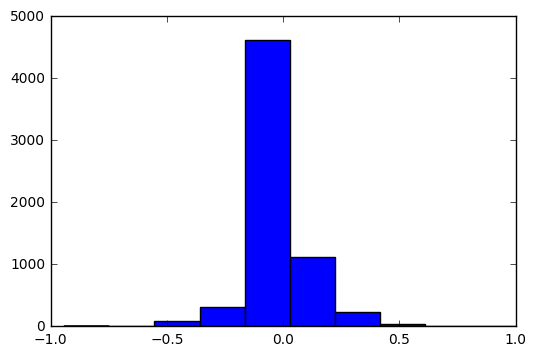

In [148]:
plt.hist(y_train)
plt.show()

In [149]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/IMG/center_2016_12_01_13_30_48_287.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


In [183]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(64, 200, 3)))

model.add(Convolution2D(24, 5, 5, border_mode='valid',subsample=(2,2),init="he_normal"))
model.add(ELU())

model.add(Convolution2D(36, 5, 5, border_mode='valid',subsample=(2,2),init="he_normal"))
model.add(ELU())

model.add(Convolution2D(48, 5, 5, border_mode='valid',subsample=(2,2),init="he_normal"))
model.add(ELU())

model.add(Convolution2D(64, 3, 3, border_mode='valid',init="he_normal"))
model.add(ELU())

model.add(Convolution2D(64, 3, 3, border_mode='valid',init="he_normal"))
model.add(ELU())

In [184]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(100,init="he_normal"))
model.add(ELU())

model.add(Dense(50,init="he_normal"))
model.add(ELU())

model.add(Dense(10,init="he_normal"))
model.add(ELU())

model.add(Dense(1,init="he_normal"))

optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_squared_error'])

# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]


In [185]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        #rescale=None, #1./255,
        #shear_range=0, #0.2,
        #zoom_range=0, #0.2,
        #horizontal_flip=False) #
)

# this is the augmentation configuration we will use for testing:
# only rescaling
# test_datagen = ImageDataGenerator(rescale=1./255)

#train_generator = train_datagen.flow(
#        'data/train',  # this is the target directory
#        target_size=(150, 150),  # all images will be resized to 150x150
#        batch_size=32,
#        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

train_generator = train_datagen.flow(
    X_train, 
    y_train, 
    batch_size=32)


In [186]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(X_train)

model.fit_generator(train_generator,
                    samples_per_epoch=len(X_train), nb_epoch=2, callbacks=callbacks_list) #samples_per_epoch = len(X_train)

#model.fit_generator(
#        train_generator,
#        samples_per_epoch=100,
#        nb_epoch=1,
#        validation_data=validation_generator,
#        nb_val_samples=800)

model.save_weights('model.h5')  # always save your weights after training or during training




Epoch 1/2
6428/6428 [==============================] - 41s - loss: 0.0119 - mean_squared_error: 0.0119    
Epoch 2/2
6428/6428 [==============================] - 41s - loss: 0.0100 - mean_squared_error: 0.0100    


In [187]:
#json_string = model.to_json()
#import json
#with open('model.json', 'w') as outfile:
#    json.dump(json_string, outfile)
    
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

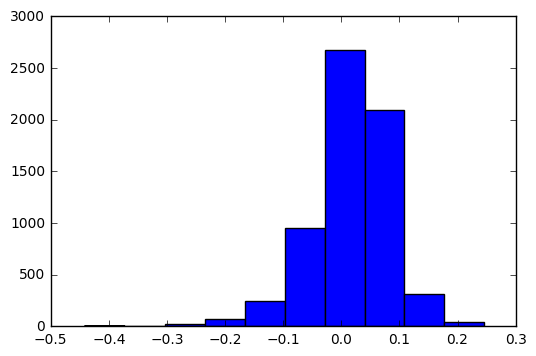

In [188]:
features = model.predict(X_train) #should replace by valid later (just want to see how it does on training)
plt.hist(features)
plt.show()

In [179]:
from keras.models import model_from_json
with open('model.json', 'r') as jfile:
    model = model_from_json(jfile.read())

In [180]:
features

array([[ 0.01891404],
       [ 0.03391305],
       [ 0.03670638],
       ..., 
       [-0.02585092],
       [ 0.04013627],
       [-0.07901129]], dtype=float32)